# **Loading Dataset**

In [12]:

# Import the necessary module
from google.colab import files
import json

# List the uploaded files
uploaded = files.upload()

# Assuming your file is named 'medical_data.json' or similar, change the name below accordingly.
file_name = list(uploaded.keys())[0]  # This will get the file name you uploaded

# Load the JSON data from the file
with open(file_name, 'r') as f:
    dataset = json.load(f)

# Print the dataset to verify
print(dataset[:2])  # Display the first 2 records to ensure it's loaded correctly


Saving dataset.json to dataset (3).json
[{'sentence': 'Mrs. May visited Leeds General Infirmary hospital located near Burley Road for her health checkup.', 'entities': [{'text': 'Mrs. May', 'label': 'Person'}, {'text': 'Leeds General Infirmary', 'label': 'Hospital'}, {'text': 'Burley Road', 'label': 'Location'}, {'text': 'Health checkup', 'label': 'MedicalProcedure'}]}, {'sentence': 'During her appointment with Dr. Ray Johnson she discussed her ongoing health issues.', 'entities': [{'text': 'Dr. Ray Johnson', 'label': 'Doctor'}, {'text': 'health issues', 'label': 'MedicalCondition'}]}]


# **Tokenization and BIO Tagging**

> Add blockquote



In [13]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenization and BIO tagging function
def tokenize_and_create_labels(sentence, entities, tokenizer):
    tokenized_sentence = tokenizer.tokenize(sentence)
    labels = ['O'] * len(tokenized_sentence)  # Initialize labels with 'O' (outside any entity)

    for entity in entities:
        entity_text = entity['text']
        entity_label = entity['label']

        # Find where the entity's tokens occur in the tokenized sentence
        tokenized_entity = tokenizer.tokenize(entity_text)
        for i, token in enumerate(tokenized_sentence):
            # Find the starting point of the entity in the tokenized sentence
            if token == tokenized_entity[0] and ' '.join(tokenized_sentence[i:i+len(tokenized_entity)]) == ' '.join(tokenized_entity):
                # Assign 'B-' for the first token and 'I-' for subsequent tokens
                labels[i] = f'B-{entity_label}'
                for j in range(1, len(tokenized_entity)):
                    labels[i+j] = f'I-{entity_label}'
                break
    return tokenized_sentence, labels

# Preprocess the entire dataset
tokenized_data = []
for item in dataset:
    sentence = item["sentence"]
    entities = item["entities"]
    tokenized_sentence, bio_labels = tokenize_and_create_labels(sentence, entities, tokenizer)
    tokenized_data.append({"tokens": tokenized_sentence, "labels": bio_labels})

# Check a sample of the tokenized data with labels
print(tokenized_data[:2])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'tokens': ['Mrs', '.', 'May', 'visited', 'Leeds', 'General', 'In', '##firmary', 'hospital', 'located', 'near', 'B', '##urley', 'Road', 'for', 'her', 'health', 'check', '##up', '.'], 'labels': ['B-Person', 'I-Person', 'I-Person', 'O', 'B-Hospital', 'I-Hospital', 'I-Hospital', 'I-Hospital', 'O', 'O', 'O', 'B-Location', 'I-Location', 'I-Location', 'O', 'O', 'O', 'O', 'O', 'O']}, {'tokens': ['During', 'her', 'appointment', 'with', 'Dr', '.', 'Ray', 'Johnson', 'she', 'discussed', 'her', 'ongoing', 'health', 'issues', '.'], 'labels': ['O', 'O', 'O', 'O', 'B-Doctor', 'I-Doctor', 'I-Doctor', 'I-Doctor', 'O', 'O', 'O', 'O', 'B-MedicalCondition', 'I-MedicalCondition', 'O']}]


# **Convert Tokenized data into Tensors**

In [14]:
import torch
from sklearn.model_selection import train_test_split

# Create a mapping from BIO labels to numeric IDs
unique_labels = set(label for example in tokenized_data for label in example['labels'])
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Function to convert tokenized data into input IDs, attention masks, and label IDs
def convert_to_tensors(tokenized_data, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    label_ids = []

    for example in tokenized_data:
        tokens = example["tokens"]
        labels = example["labels"]

        # Convert tokens to input IDs
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_id)
        label_id = [label_to_id[label] for label in labels]

        # Padding for uniform length
        padding_length = max_length - len(input_id)
        input_ids.append(input_id + [0] * padding_length)  # Pad input IDs with 0
        attention_masks.append(attention_mask + [0] * padding_length)  # Pad mask with 0
        label_ids.append(label_id + [-100] * padding_length)  # Pad labels with -100 to ignore during training

    return torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(label_ids)

# Convert tokenized data to tensors
input_ids, attention_masks, label_ids = convert_to_tensors(tokenized_data, tokenizer)

# Split the data into training and testing sets
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    input_ids, label_ids, attention_masks, test_size=0.2
)

# Check tensor shapes
print(train_inputs.shape, train_labels.shape, train_masks.shape)


torch.Size([449, 128]) torch.Size([449, 128]) torch.Size([449, 128])


# **Model Training**

In [15]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# Define number of unique labels
num_labels = len(unique_labels)

# Load pre-trained BERT for token classification
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
)

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, label_ids):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.label_ids = label_ids

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        # Return a dictionary containing the inputs
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.label_ids[idx],
        }

# Create dataset instances
train_dataset = CustomDataset(train_inputs, train_masks, train_labels)
eval_dataset = CustomDataset(test_inputs, test_masks, test_labels)

# Initialize the Trainer with model and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Use the custom datasets
    eval_dataset=eval_dataset
)

# Fine-tune the model
trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.967525
2,No log,0.385008
3,No log,0.272863
4,0.852500,0.245612
5,0.852500,0.236958
6,0.852500,0.235186
7,0.075700,0.229209
8,0.075700,0.246970
9,0.075700,0.233660
10,0.075700,0.250524


TrainOutput(global_step=435, training_loss=0.22146307719849992, metrics={'train_runtime': 172.2951, 'train_samples_per_second': 39.09, 'train_steps_per_second': 2.525, 'total_flos': 440081720904960.0, 'train_loss': 0.22146307719849992, 'epoch': 15.0})

# **Saving the pretrained model**

In [18]:
model_save_path = "model.pt"

# Save the model's state dict
torch.save(model.state_dict(), model_save_path)

print(f"Model saved as {model_save_path}")


Model saved as model.pt


# **Loading the Save Trained Model**

In [ ]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=num_labels)
model.load_state_dict(torch.load("model.pt"))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-645419f5dd02>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

<All keys matched successfully>

# **Confusion Matrix and Classification Report**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

                      precision    recall  f1-score   support

        B-Medication       1.00      1.00      1.00        25
            I-Person       1.00      0.50      0.67         4
            B-Person       0.99      0.98      0.99       133
          B-Location       1.00      0.85      0.92        13
  B-MedicalCondition       1.00      0.50      0.67         2
          I-Facility       1.00      0.96      0.98        28
          B-Behavior       0.67      1.00      0.80         2
B-HospitalDepartment       0.90      1.00      0.95        63
           I-Outcome       0.89      0.93      0.91        89
        I-Medication       0.00      0.00      0.00         1
          I-Behavior       0.98      0.98      0.98        54
             I-Group       0.98      0.95      0.97       908
      B-MedicalField       0.87      0.87      0.87        23
  I-MedicalCondition       0.67      1.00      0.80         4
            B-Doctor       1.00      1.00      1.00        64
       

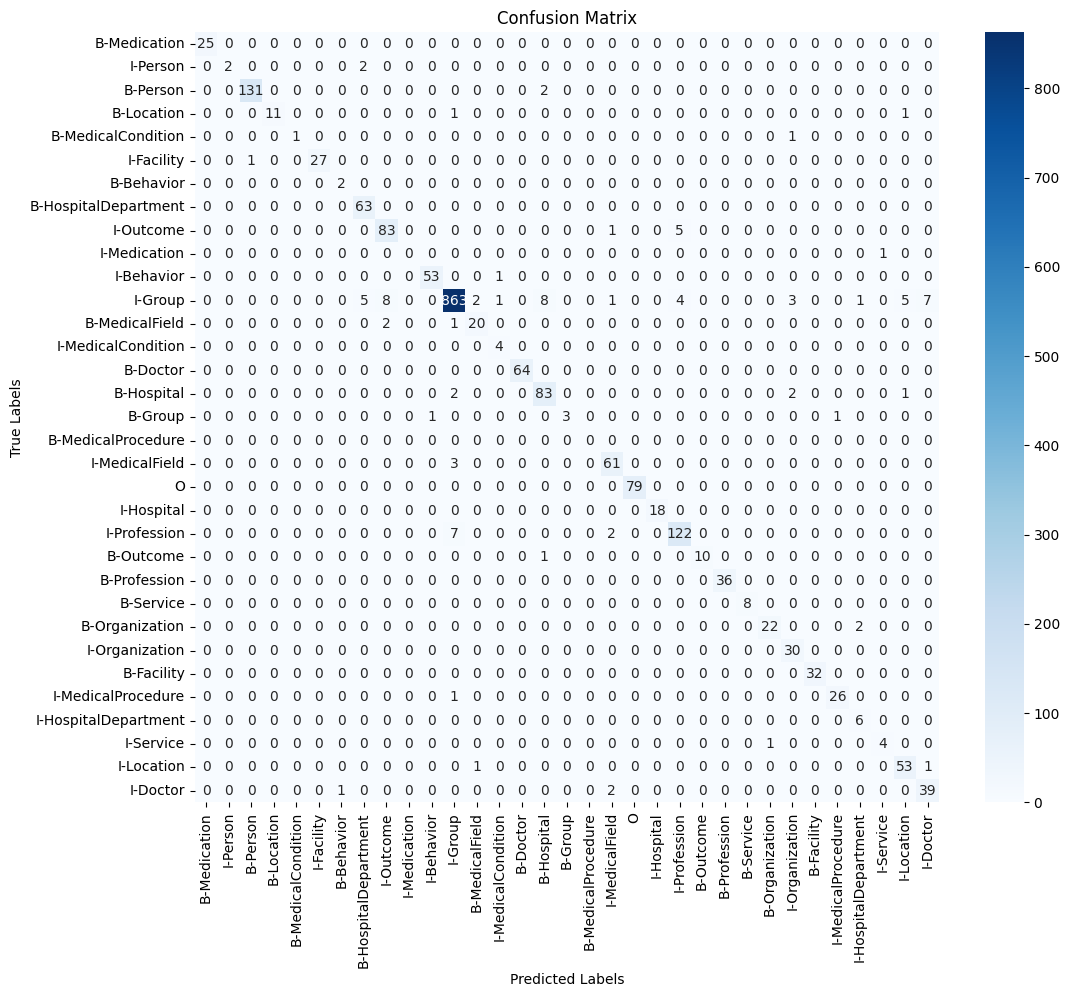

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values for classification report and confusion matrix
label_encoder = LabelEncoder()
all_labels = list(label_to_id.keys())  # All unique BIO labels
label_encoder.fit(all_labels)

# Generate predictions on the evaluation dataset
predictions, _, _ = trainer.predict(eval_dataset)

# Convert predictions to label indices
pred_labels = np.argmax(predictions, axis=-1)

# Retrieve true labels from eval_dataset using a loop
true_labels = []
for example in eval_dataset:
    true_labels.append(example['labels'])

# Flatten the labels and predictions, removing padding and ignored tokens (-100)
def flatten_predictions(predictions, true_labels):
    y_true_flat = []
    y_pred_flat = []

    for i in range(len(true_labels)):
        for j in range(len(true_labels[i])):
            if true_labels[i][j] != -100:  # Exclude padding/ignored tokens
                y_true_flat.append(true_labels[i][j])
                y_pred_flat.append(predictions[i][j])

    # Convert numeric labels back to BIO tag names
    y_true_flat = label_encoder.inverse_transform(y_true_flat)
    y_pred_flat = label_encoder.inverse_transform(y_pred_flat)

    return y_true_flat, y_pred_flat

# Flatten predictions and true labels
y_true, y_pred = flatten_predictions(pred_labels, true_labels)

# Print classification report
report = classification_report(y_true, y_pred, labels=all_labels, output_dict=True)
print(classification_report(y_true, y_pred, labels=all_labels))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_labels)

# Display the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=all_labels, yticklabels=all_labels, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()




# **NER Inferences Prediction**

In [ ]:
import torch
from transformers import BertTokenizer, BertForTokenClassification
import json

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(unique_labels)
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=num_labels)
model.load_state_dict(torch.load("model.pt", map_location=device))
model.to(device)
model.eval()

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Function to predict entities in JSON format and token-level format
def predict(sentence, model, tokenizer, label_map, max_length=128):
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    predicted_label_ids = torch.argmax(logits, dim=2).squeeze().tolist()
    predicted_labels = [id_to_label[label_id] for label_id in predicted_label_ids]
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    # Print token-level predictions
    print("Token-Level Predictions:")
    token_predictions = [{"token": token, "label": label} for token, label in zip(tokens, predicted_labels) if token not in ['[PAD]', '[CLS]', '[SEP]']]
    print(json.dumps(token_predictions, indent=2))

    # Process for JSON output
    entities = []
    current_entity = []
    current_label = None

    for token, label in zip(tokens, predicted_labels):
        if token in ['[PAD]', '[CLS]', '[SEP]']:
            continue
        if label.startswith("B-"):
            if current_entity:
                entities.append({"text": "".join(current_entity).replace("##", ""), "label": current_label})
            current_entity = [token]
            current_label = label[2:]
        elif label.startswith("I-") and current_label == label[2:]:
            current_entity.append(token if token.startswith("##") else " " + token)
        else:
            if current_entity:
                entities.append({"text": "".join(current_entity).replace("##", ""), "label": current_label})
            current_entity = []
            current_label = None

    if current_entity:
        entities.append({"text": "".join(current_entity).replace("##", ""), "label": current_label})

    # Return in JSON format
    return {
        "sentence": sentence,
        "entities": entities
    }

# Example usage
sentence = input("Enter a sentence for entity recognition: ")
predicted_entities = predict(sentence, model, tokenizer, id_to_label)

# Print output in JSON format
print("\nEntity-Level JSON Output:")
print(json.dumps(predicted_entities, indent=2))



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-25-05d8c3bac835>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

Enter a sentence for entity recognition: Mrs. Williams attends physical therapy to improve her mobility after hip replacement surgery.
Token-Level Predictions:
[
  {
    "token": "Mrs",
    "label": "B-Person"
  },
  {
    "token": ".",
    "label": "I-Person"
  },
  {
    "token": "Williams",
    "label": "I-Person"
  },
  {
    "token": "attends",
    "label": "O"
  },
  {
    "token": "physical",
    "label": "B-Service"
  },
  {
    "token": "therapy",
    "label": "I-Service"
  },
  {
    "token": "to",
    "label": "O"
  },
  {
    "token": "improve",
    "label": "B-Outcome"
  },
  {
    "token": "her",
    "label": "O"
  },
  {
    "token": "mobility",
    "label": "B-Outcome"
  },
  {
    "token": "after",
    "label": "O"
  },
  {
    "token": "hip",
    "label": "B-MedicalProcedure"
  },
  {
    "token": "replacement",
    "label": "I-MedicalProcedure"
  },
  {
    "token": "surgery",
    "label": "I-MedicalProcedure"
  },
  {
    "token": ".",
    "label": "O"
  }
]

Entity